# predict philly property price

The goal of this project is to predict the value of homes in Philadelphia and identify features that drive up home value. 

Property data is sourced from OpenDataPhilly and the City of Philadelphia Office of Property Assessment: https://www.phila.gov/property/data/#

Info features in the dataset were downloaded from this url: https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In addition to the information in the above dataset, additional information on school locations will be used to calculate proximity to schools: https://www.opendataphilly.org/dataset/schools/resource/8e1bb3e6-7fb5-4018-95f8-63b3fc420557

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle
from statsmodels.graphics.mosaicplot import mosaic
import ppscore as pps

In [2]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_pickle('interim_data/df_cleaned')
target = 'market_value'
figdir = 'plots'

In [5]:
plt.rcParams['figure.figsize'] = [8.0, 4.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

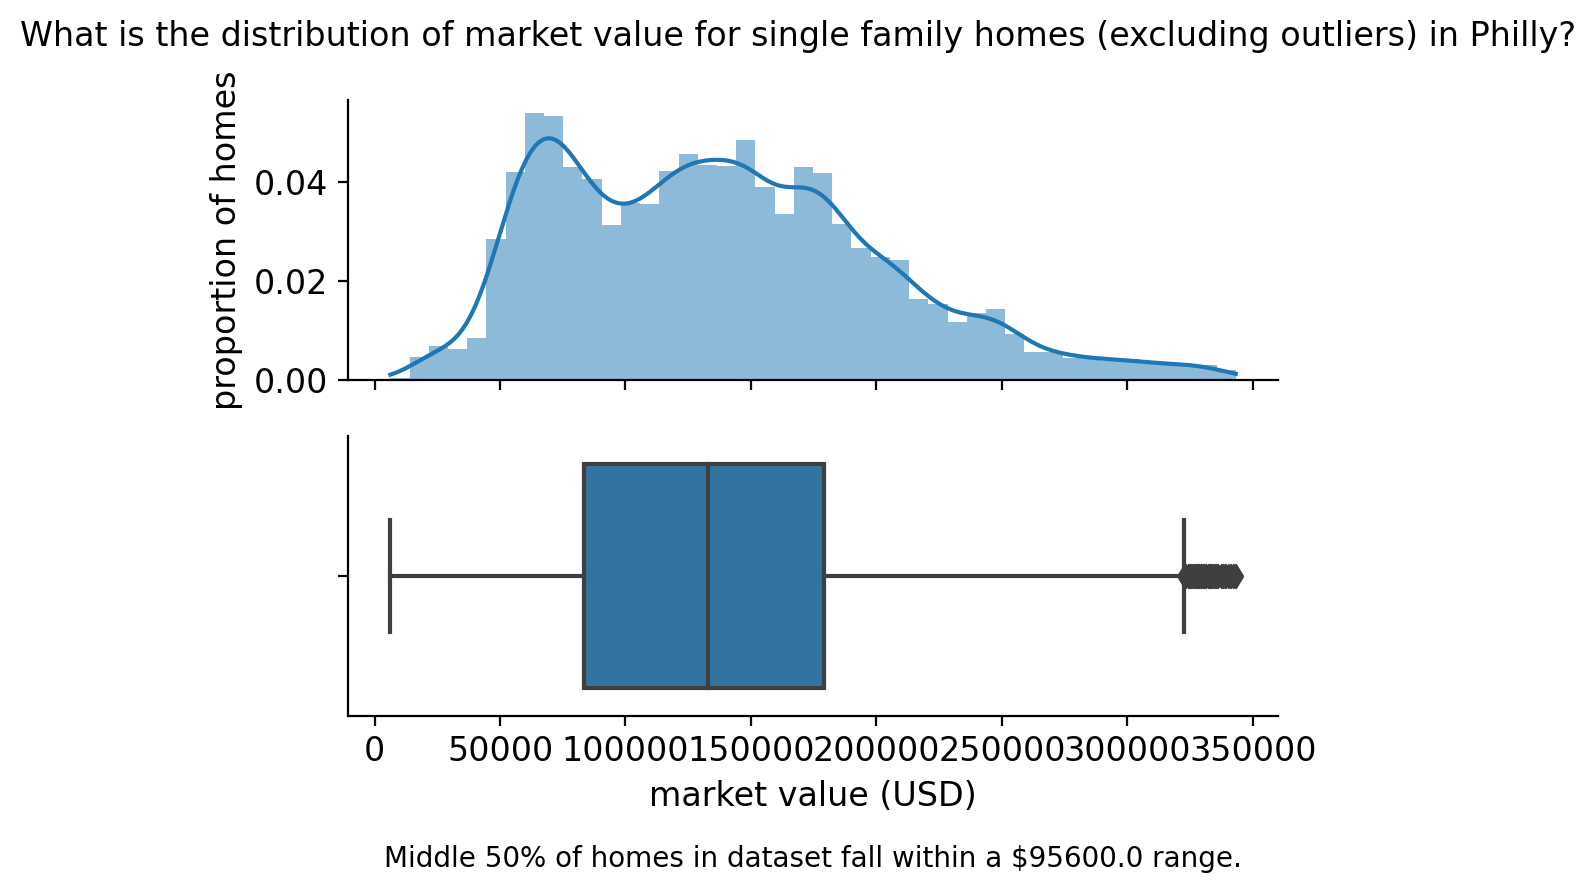

Upper 25% of homes in dataset fall within a $164100.0 range.


In [28]:
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(6,4),sharex=True)

h = sns.histplot(ax=ax[0],data=df,x=df[target],kde=True,edgecolor='none',linewidth=.3,stat='probability',common_norm=False)
sns.despine()
ax[0].set_ylabel('proportion of homes')

sns.boxplot(ax=ax[1],data=df,x=df[target])
ax[1].set_title('Middle 50% of homes in dataset fall within a $' + str(np.quantile(df[target],0.75)-np.quantile(df[target],0.25)) + ' range.',fontsize=10,y=-0.6)
ax[1].set_xlabel('market value (USD)')

plt.suptitle('What is the distribution of market value for single family homes (excluding outliers) in Philly?')

plt.show()

figname = os.path.join(figdir,'marketvalue_dist.png')
fig.savefig(figname,dpi=400,orientation='portrait', transparent=True,bbox_inches='tight')

print('Upper 25% of homes in dataset fall within a $' + str(np.quantile(df[target],1.0)-np.quantile(df[target],0.75)) + ' range.')


Look at the distribution of numerical variables and their correlations with the target variable:

In [7]:
numdf = df.select_dtypes(['float'])
numdf['year_built'] = df['year_built']

In [8]:
graded  = ['interior_condition','exterior_condition']
schdist = ['km_to_elementary', 'km_to_middle', 'km_to_high']
loc     = ['lat','lng']
exclude = list()
for i in schdist:
    exclude.append(i)
for i in loc:
    exclude.append(i)
for i in graded:
    exclude.append(i)   
exclude.append(target)
predictors = [column for column in numdf.columns if column not in exclude]

In [9]:
discrete  = list()
continous = list()
for x in predictors:
    if x.__contains__('number'):
        discrete.append(x)
discrete.append('garage_spaces')

for x in predictors:
    if x not in discrete:
        continous.append(x)

Look at the relationship between the numeric variables and their correlation with the target variable:

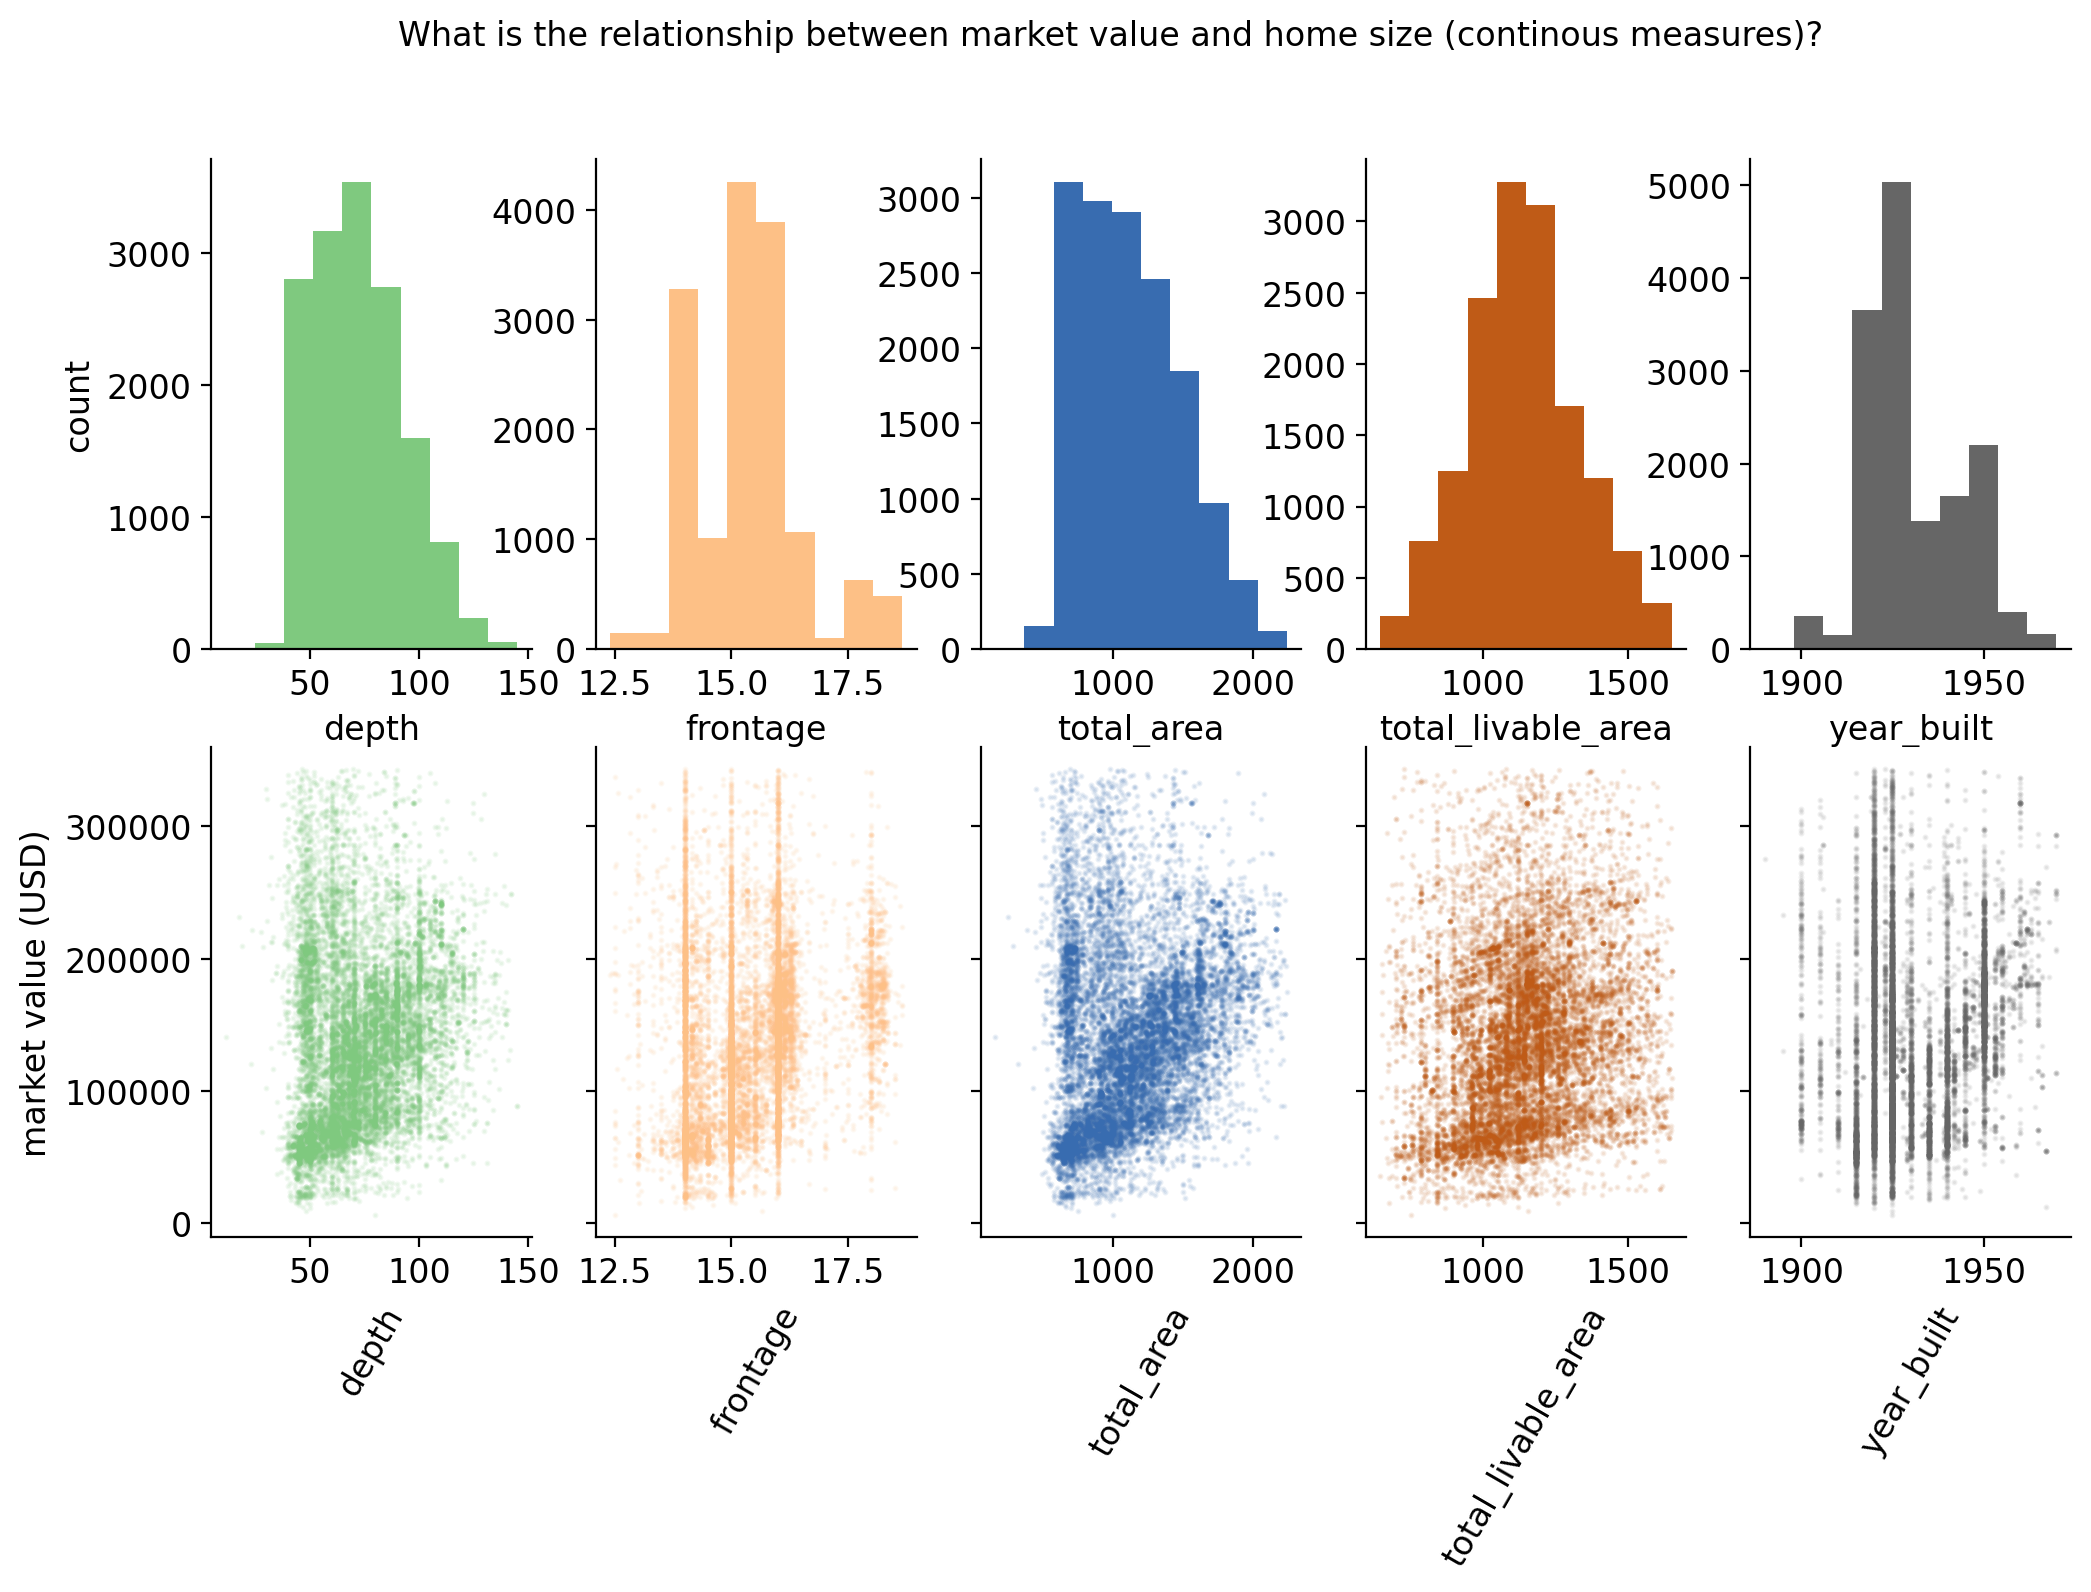

In [26]:
colors = plt.cm.get_cmap('Accent')
its = np.linspace(0,1,num=int(len(continous)))

fig,ax=plt.subplots(nrows=2,ncols=int(len(continous)),figsize=(12,7))

cnt =0
for predictor in continous:
    ax[0,cnt].hist(numdf[predictor],color=colors(its[cnt]))
    sns.despine()
    ax[0,cnt].ticklabel_format(style='plain')
    ax[0,cnt].set_xlabel(predictor,rotation=0)
    #ax[0,cnt].set_xscale('log')
    if cnt == 0:
        ax[0,cnt].set_ylabel('count')
    cnt += 1


cnt =0
for predictor in continous:
    ax[1,cnt].scatter(numdf[predictor],numdf[target],s=1.25,alpha=0.1,color=colors(its[cnt]))
    sns.despine()
    ax[1,cnt].ticklabel_format(style='plain')
    ax[1,cnt].set_xlabel(predictor,rotation=60)
    #ax[1,cnt].set_xscale('log')
    if cnt > 0:
        ax[1,cnt].yaxis.set_ticklabels([])
    if cnt == 0:
        ax[1,cnt].set_ylabel('market value (USD)')
    cnt += 1

plt.suptitle('What is the relationship between market value and home size (continous measures)?')
plt.show()

figname = os.path.join(figdir,'marketvalue_homesize.png')
fig.savefig(figname,dpi=400,orientation='portrait', transparent=True,bbox_inches='tight')

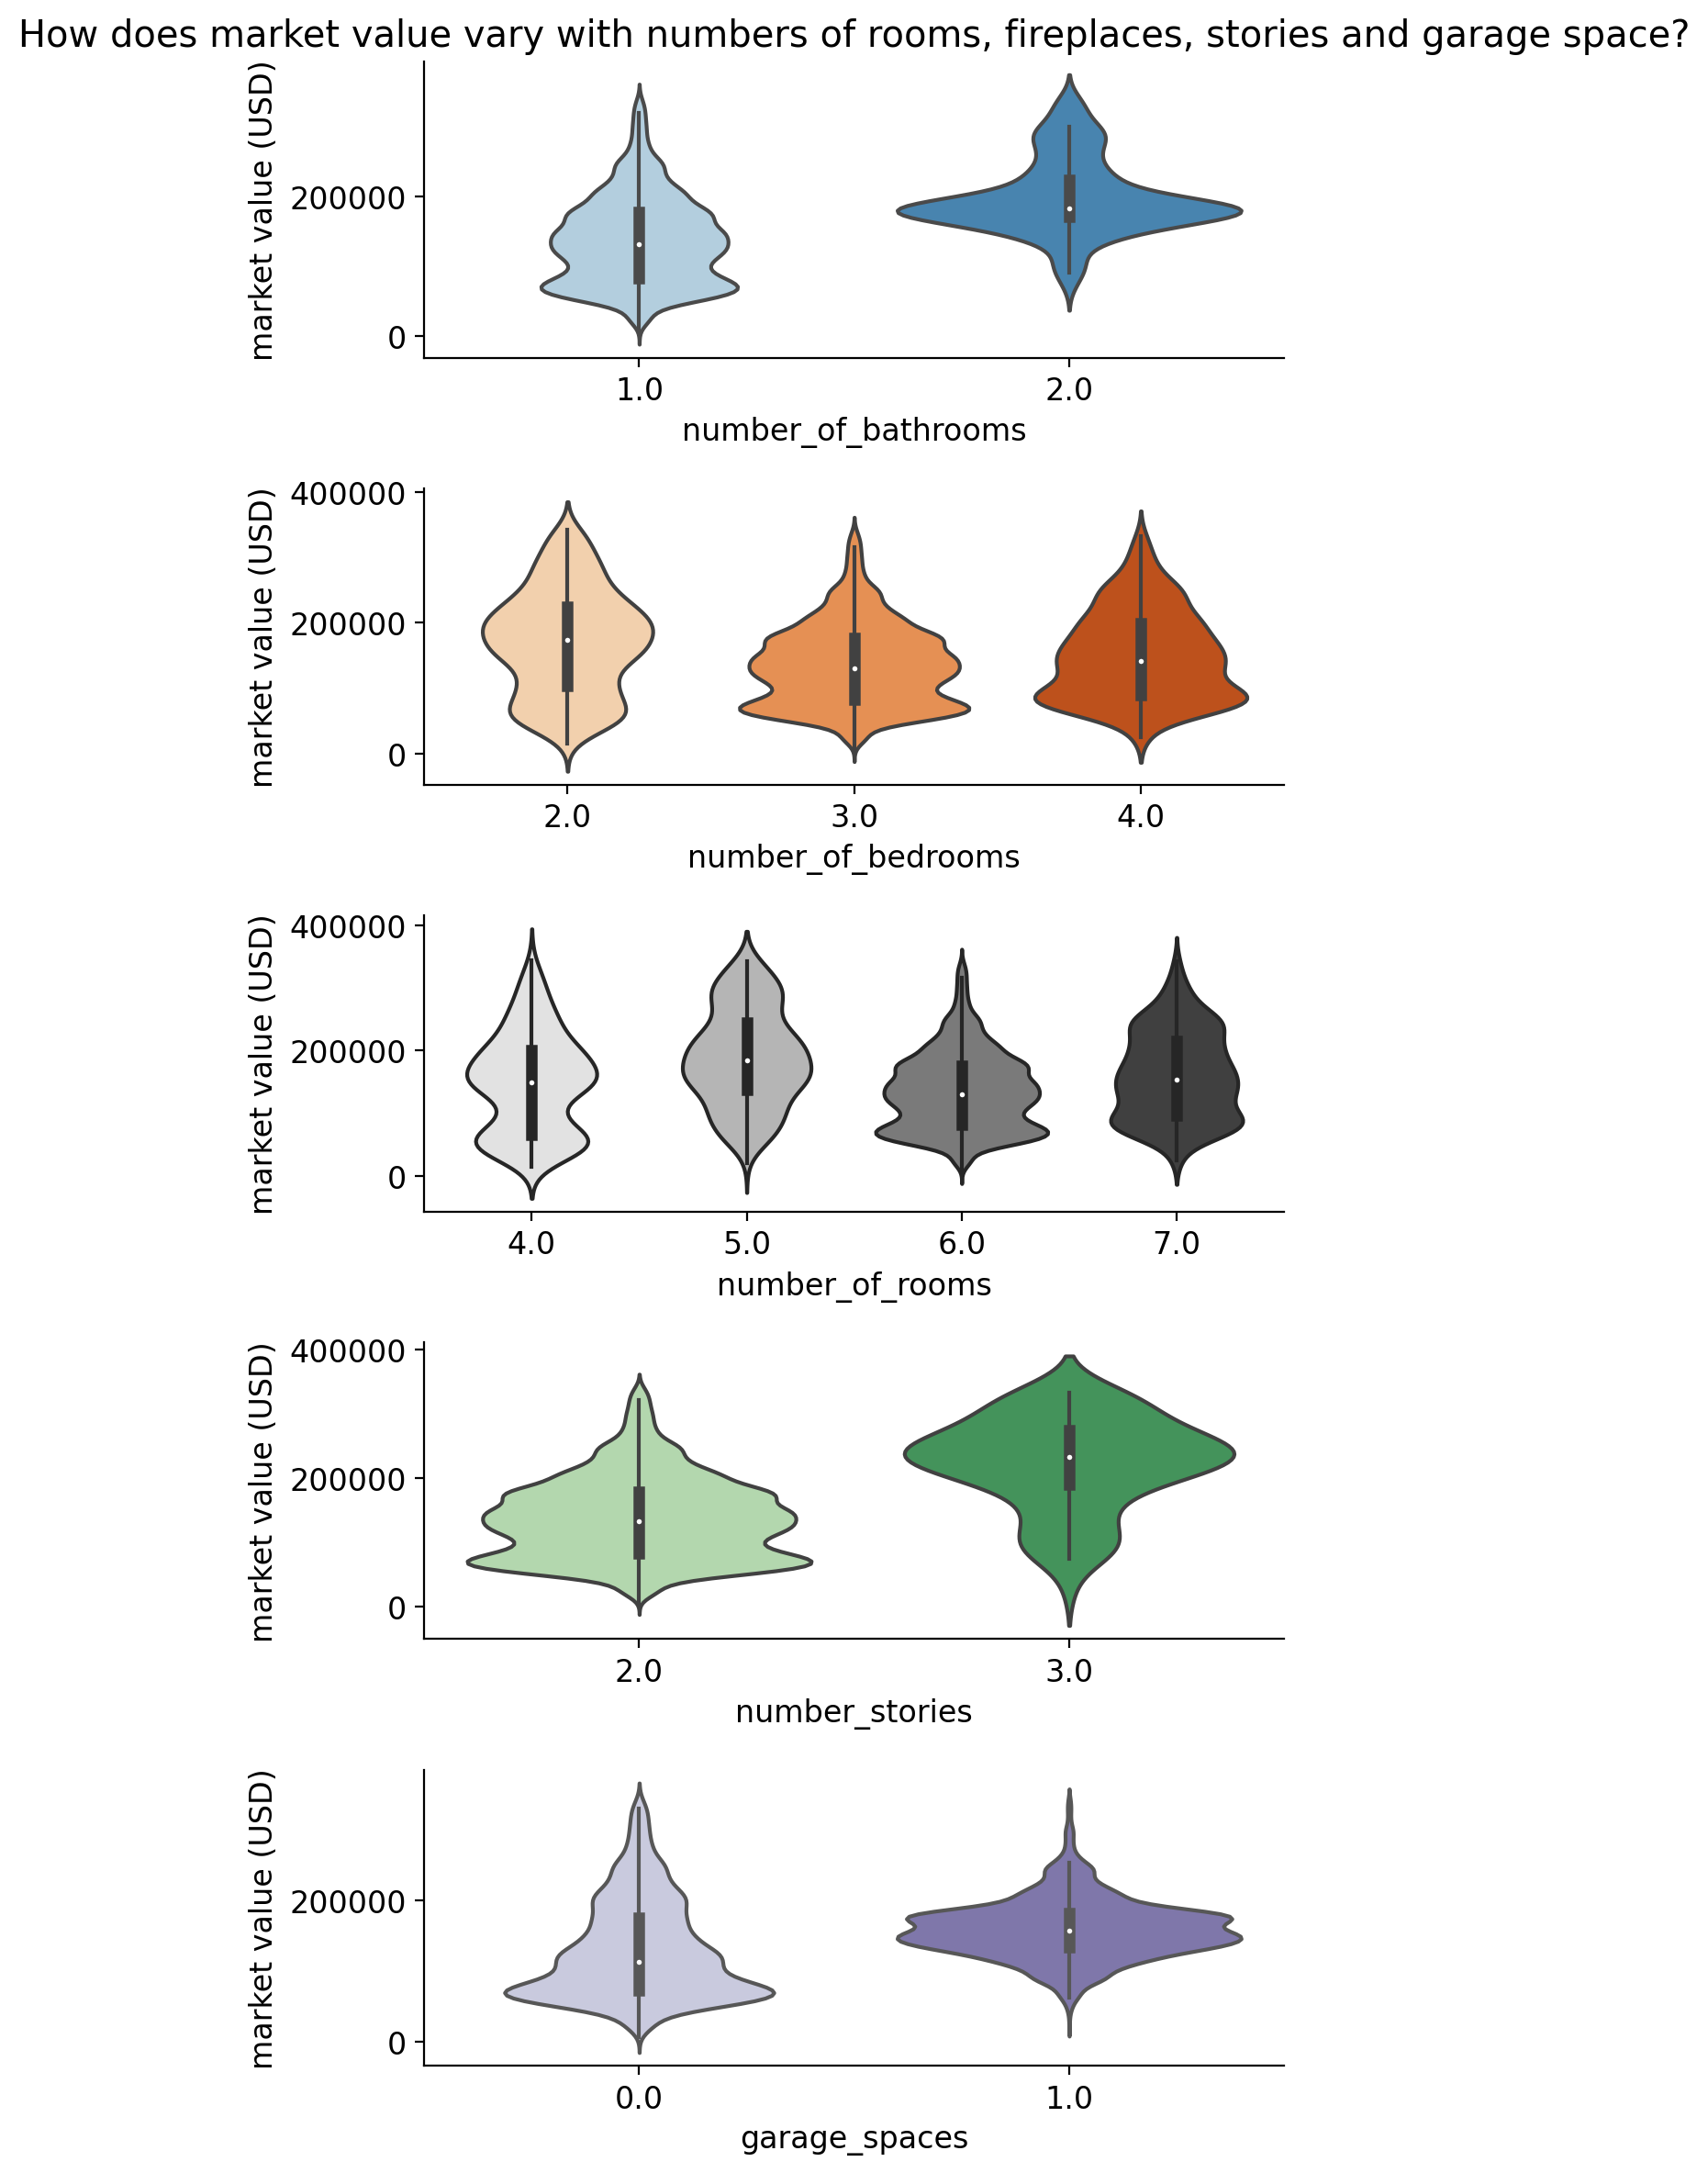

In [11]:
fig,ax=plt.subplots(ncols=1,nrows=len(discrete),figsize=(6,12))
cnt = 0
ax[0].set_title('How does market value vary with numbers of rooms, fireplaces, stories and garage space?')
cps = ['Blues','Oranges','Greys','Greens','Purples']
for predictor in discrete:
    sns.violinplot(data=df,x=predictor,y=target,ax=ax[cnt],palette=cps[cnt])
    ax[cnt].set_xlabel(predictor)
    ax[cnt].set_ylabel('market value (USD)')
    sns.despine()
    plt.tight_layout()
    cnt += 1
plt.show()

figname = os.path.join(figdir,'marketvalue_discretenum.png')
fig.savefig(figname,dpi=400,orientation='portrait', transparent=True,bbox_inches='tight')

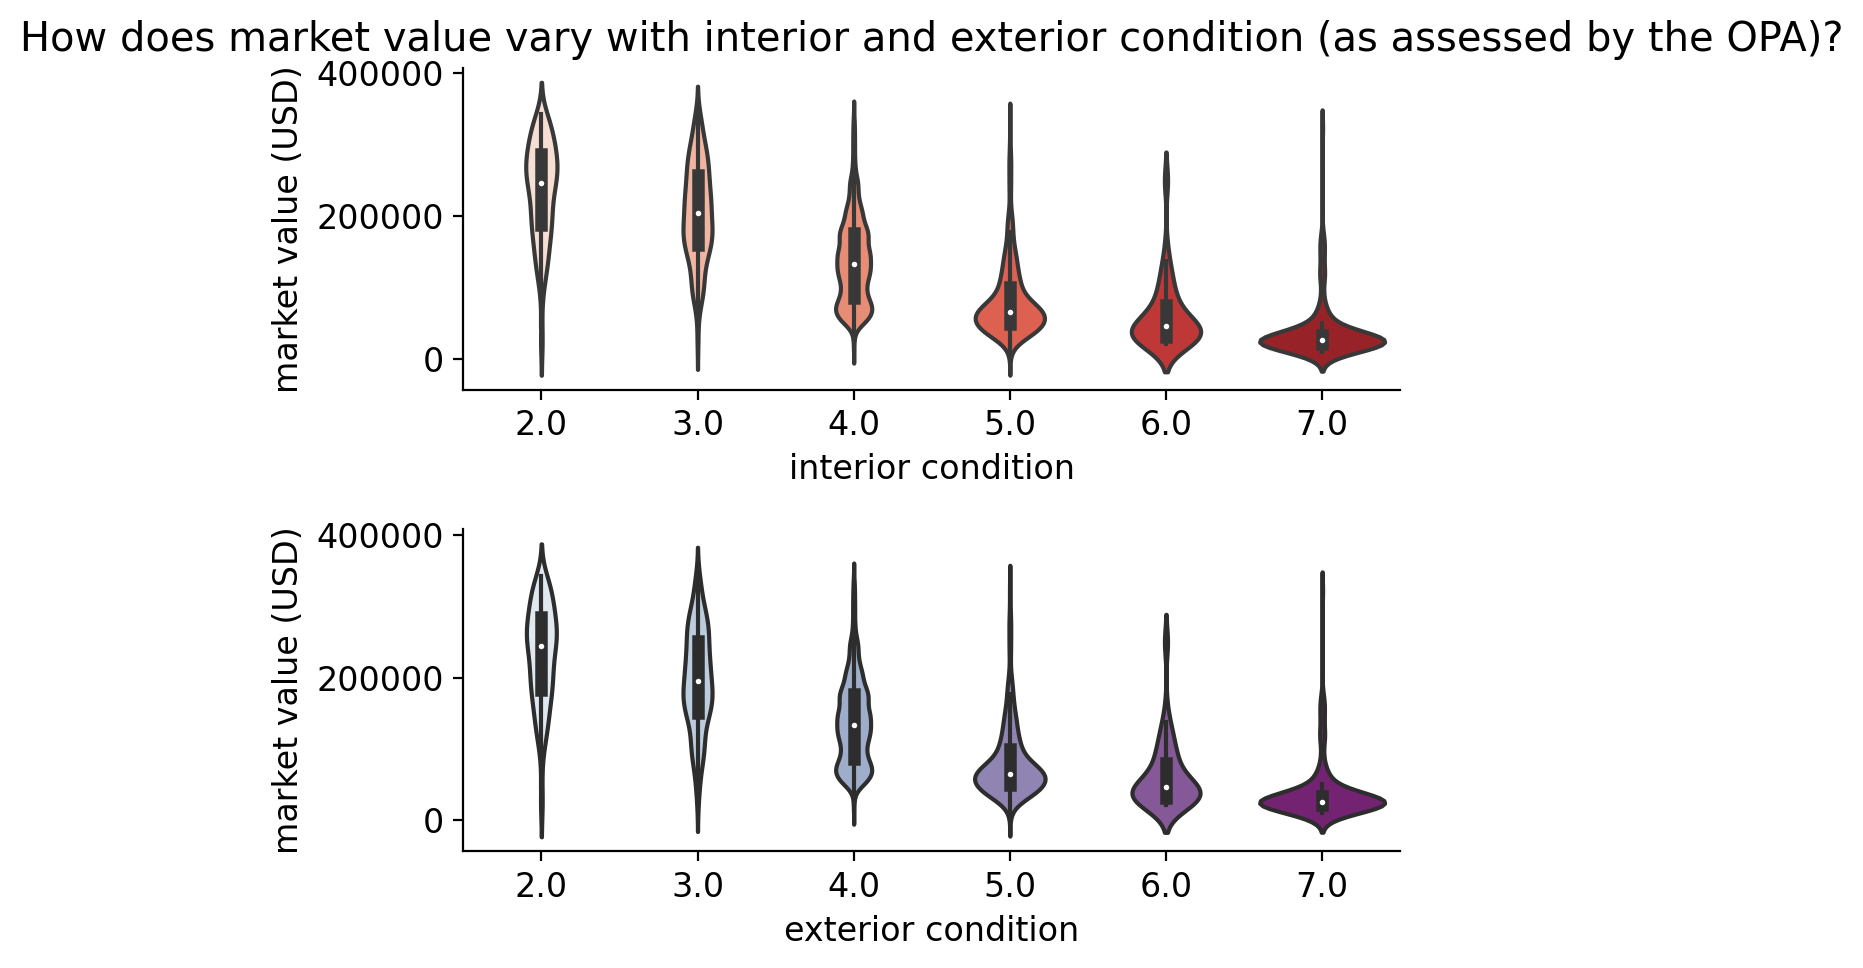

In [12]:
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,5))
cnt = 0
ax[0].set_title('How does market value vary with interior and exterior condition (as assessed by the OPA)?')

sns.violinplot(data=df,x='interior_condition',y=target,ax=ax[0],palette='Reds')
ax[0].set_xlabel('interior condition')
ax[0].set_ylabel('market value (USD)')
sns.despine()
plt.tight_layout()

sns.violinplot(data=df,x='exterior_condition',y=target,ax=ax[1],palette='BuPu')
ax[1].set_xlabel('exterior condition')
ax[1].set_ylabel('market value (USD)')

sns.despine()
plt.tight_layout()

plt.show()

figname = os.path.join(figdir,'marketvalue_condition.png')
fig.savefig(figname,dpi=400,orientation='portrait', transparent=True,bbox_inches='tight')

In [13]:
df['interior_condition'].value_counts()

4.0    13418
3.0      545
5.0      479
2.0      303
7.0      185
6.0       70
Name: interior_condition, dtype: int64

Look at the relationship between categorical variables and the target variable:

In [14]:
catdict = {'central_air':{0.0:'no',1.0:'yes'},\
           'basements':{'0':'none','A':'full finished','B':'full semi-finished','C':'full unfinished','D':'full unknown finish',\
                       'E':'partial finished','F':'partial semi-finished','G':'partial unfinished','H':'partial unknown finish',\
                       'I':'finished-unknown size','J':'unfinished-unknown size'},\
          'garage_type':{'0':'none','A':'built in basement','B':'attached garage','C':'detached garage',\
                        'F':'converted'},\
          'type_heater':{'H':'undetermined','A':'hot air (ducts)','B':'hot water (radiators/baseboards)','G':'radiant',\
                         'C':'electric baseboard','E':'other','D':'heat pump (outside unit)'},\
          'view':{'0':'na','I':'typical','A':'cityscape','C':'park/green area','B':'flowing water'}}

In [15]:
catdf = df.select_dtypes('category')

In [16]:
for column in catdf:
    prop = df[column].value_counts(normalize=True).reset_index()
    rm_vals = list(prop['index'][prop[column] == 0])
    for rm in rm_vals:
        q = "{column} != '{rm}' ".format(column=column,rm=rm)
        df = df.query(q)
        df[column] = df[column].cat.remove_categories(rm)

In [17]:
df.to_pickle('interim_data/df_cleaned')

In [18]:
verbdf = df
for column in catdf:
    if column in list(catdict.keys()):
        verbdf[column] = verbdf[column].replace(catdict[column])

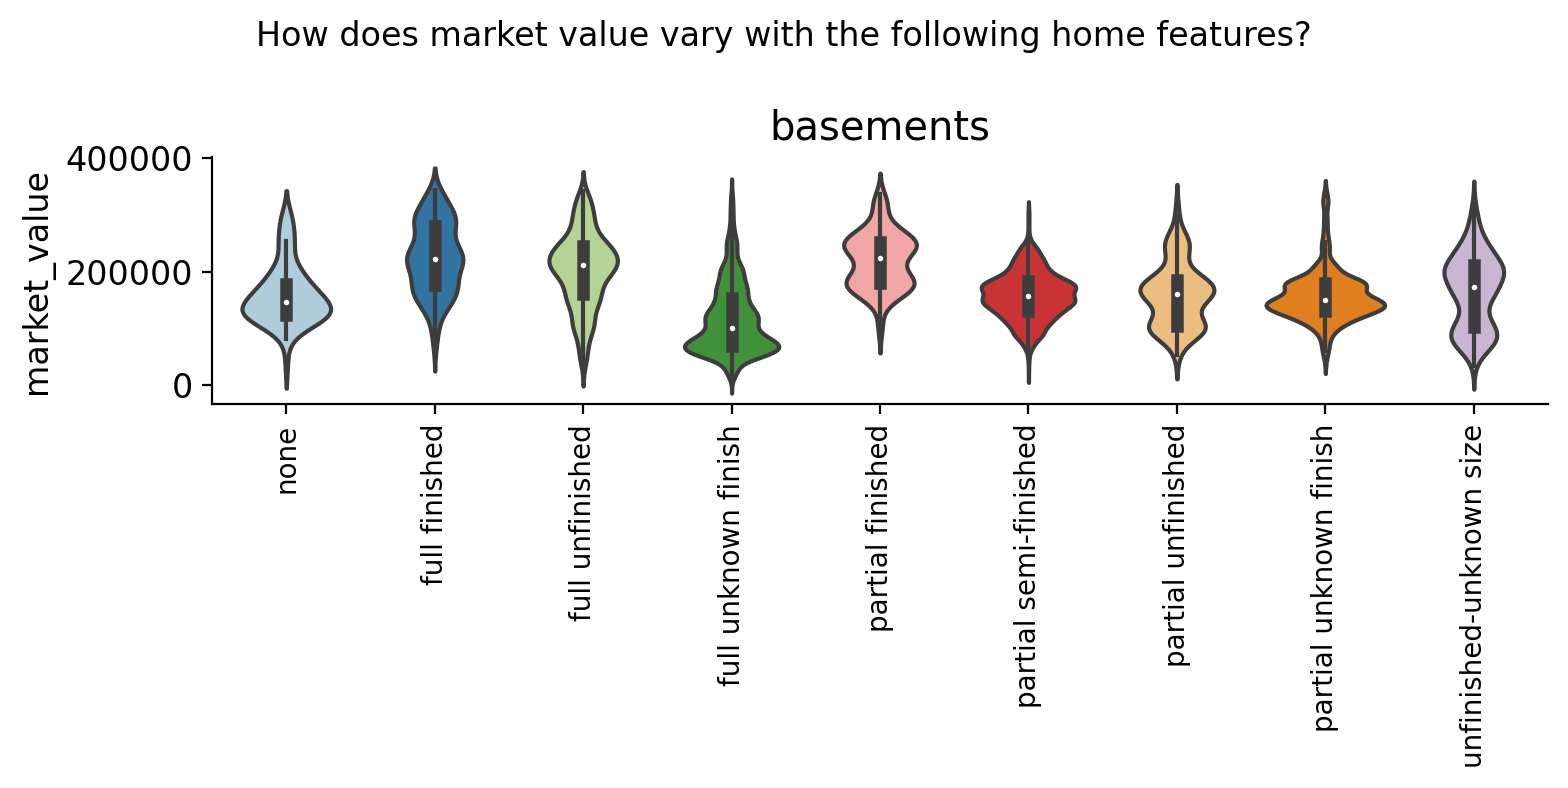

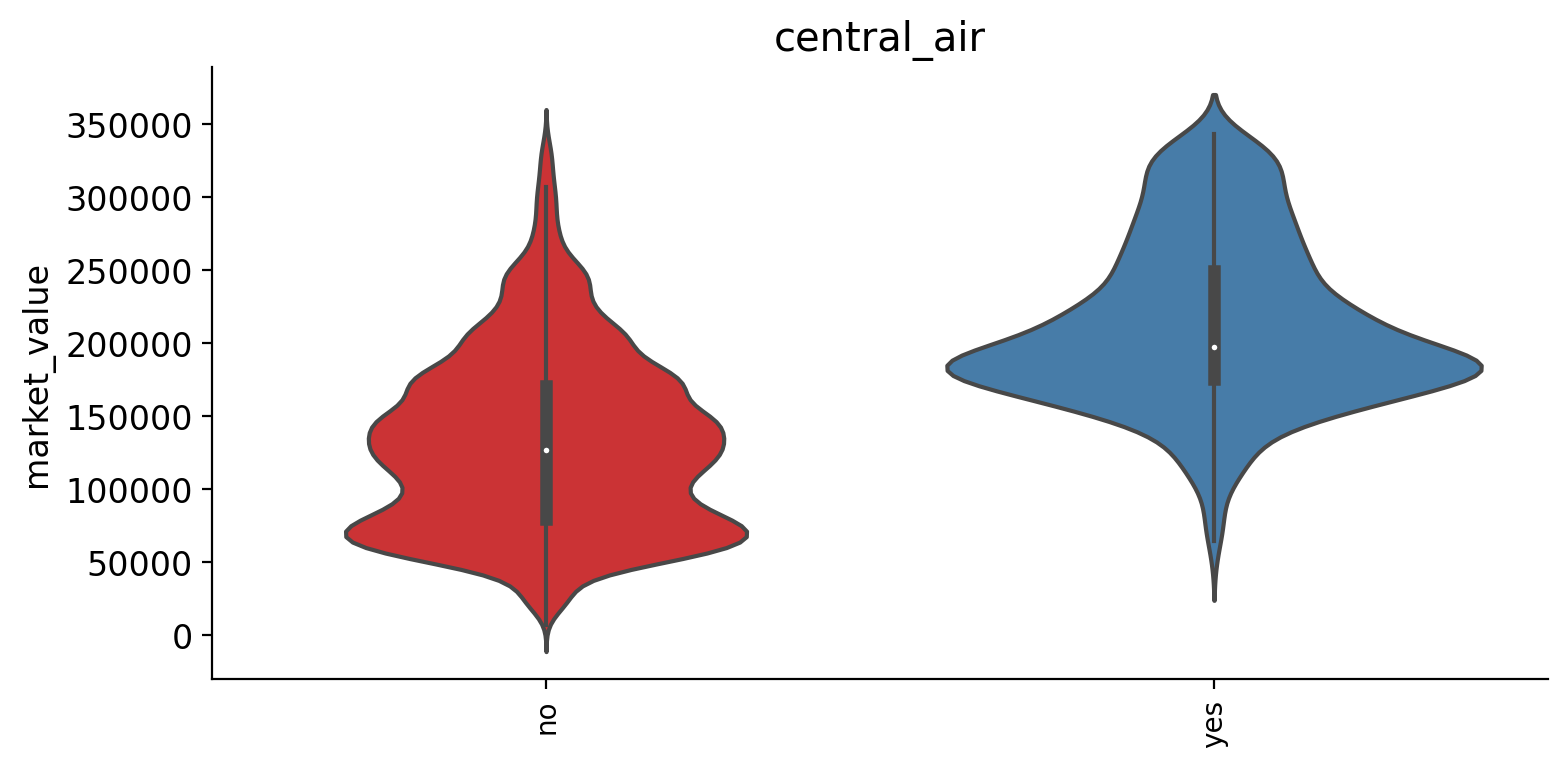

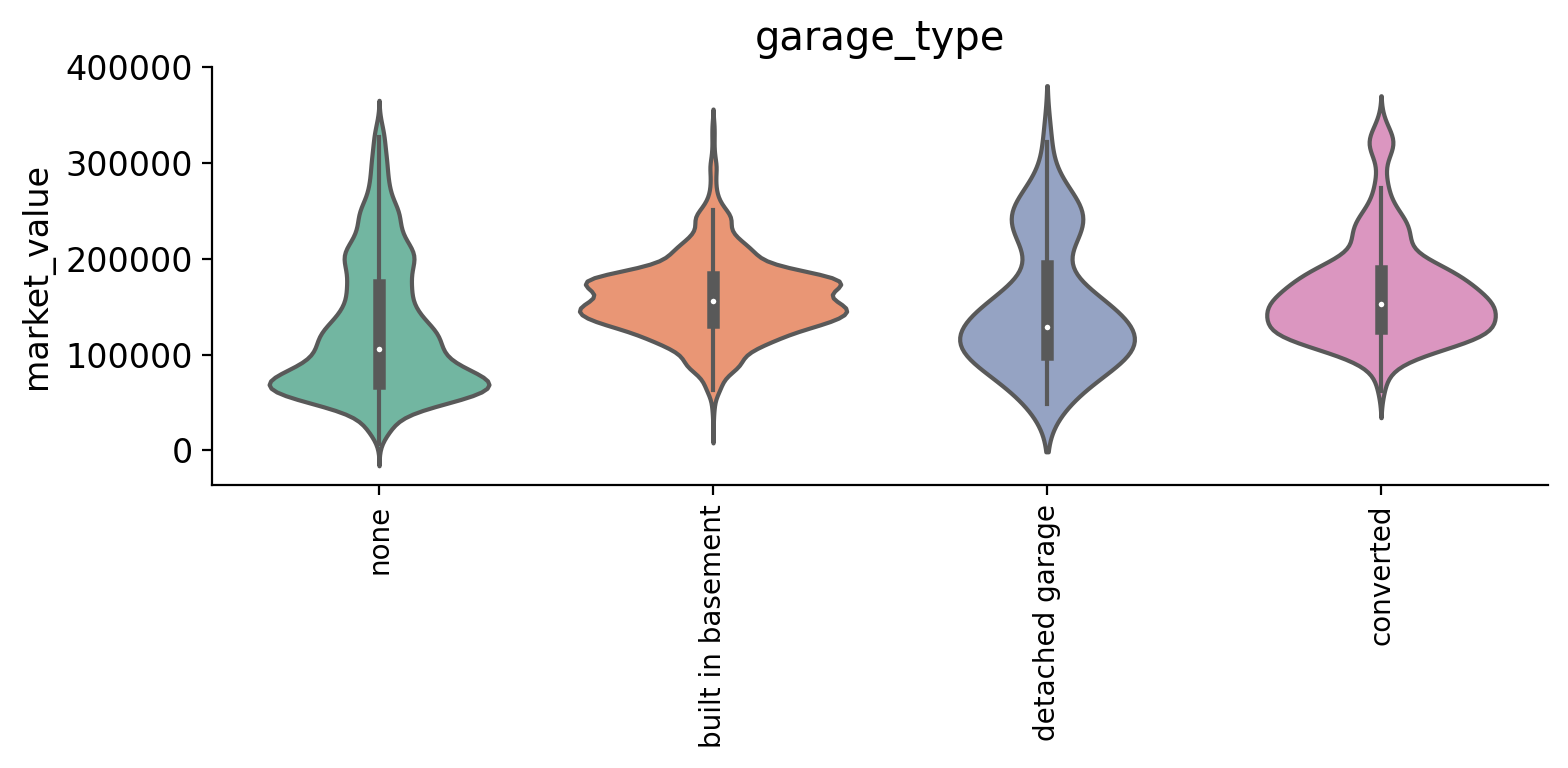

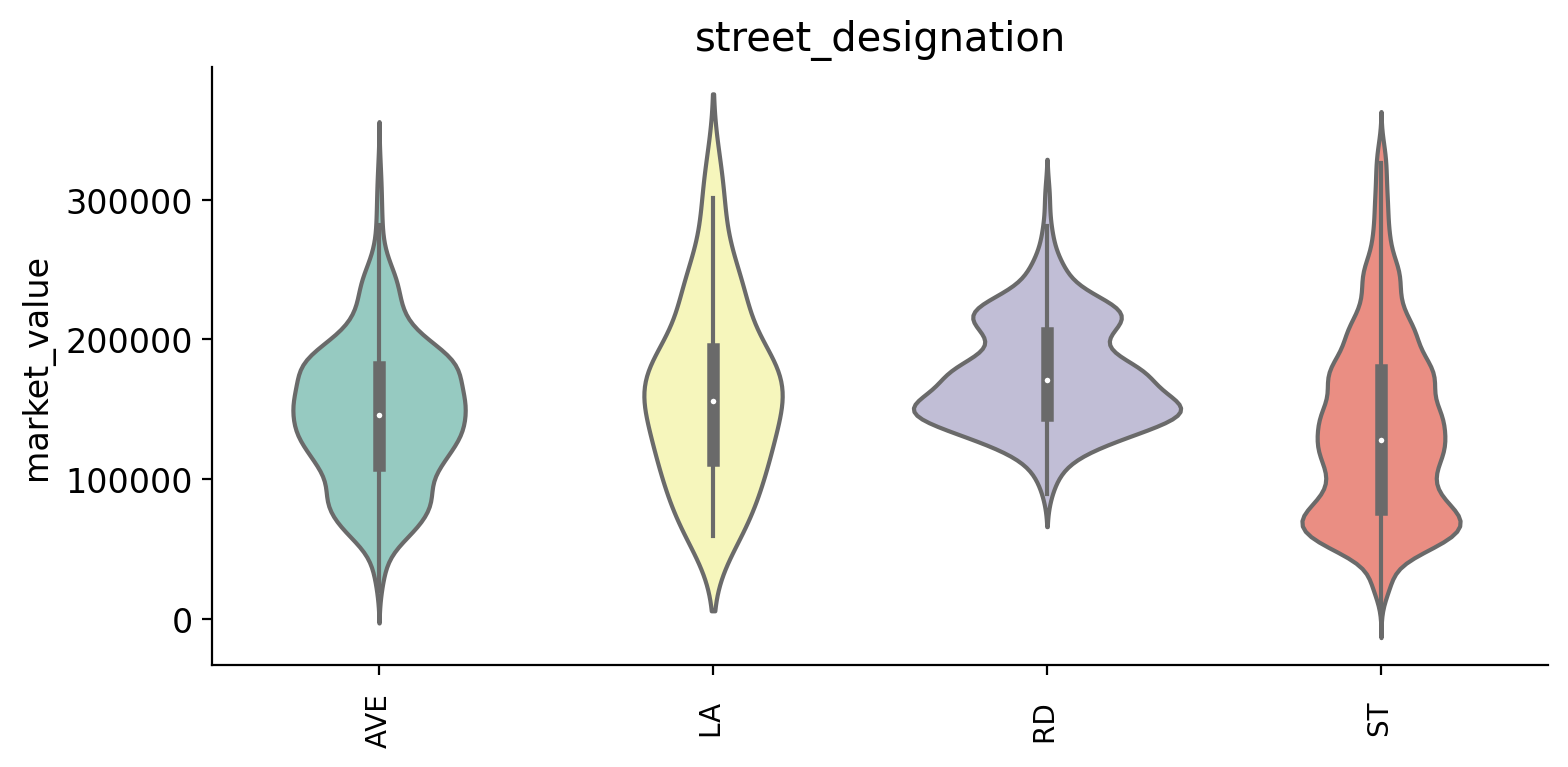

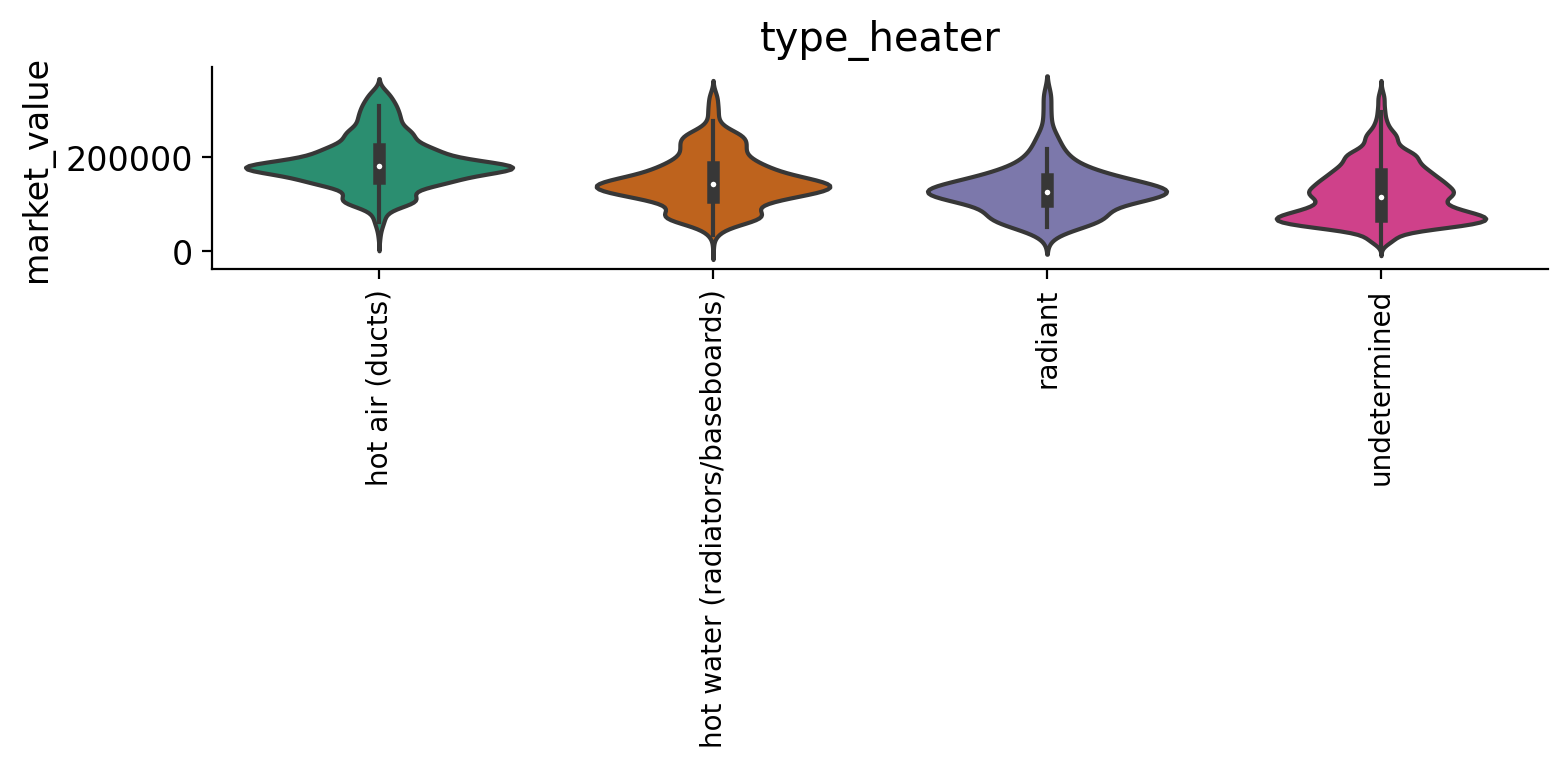

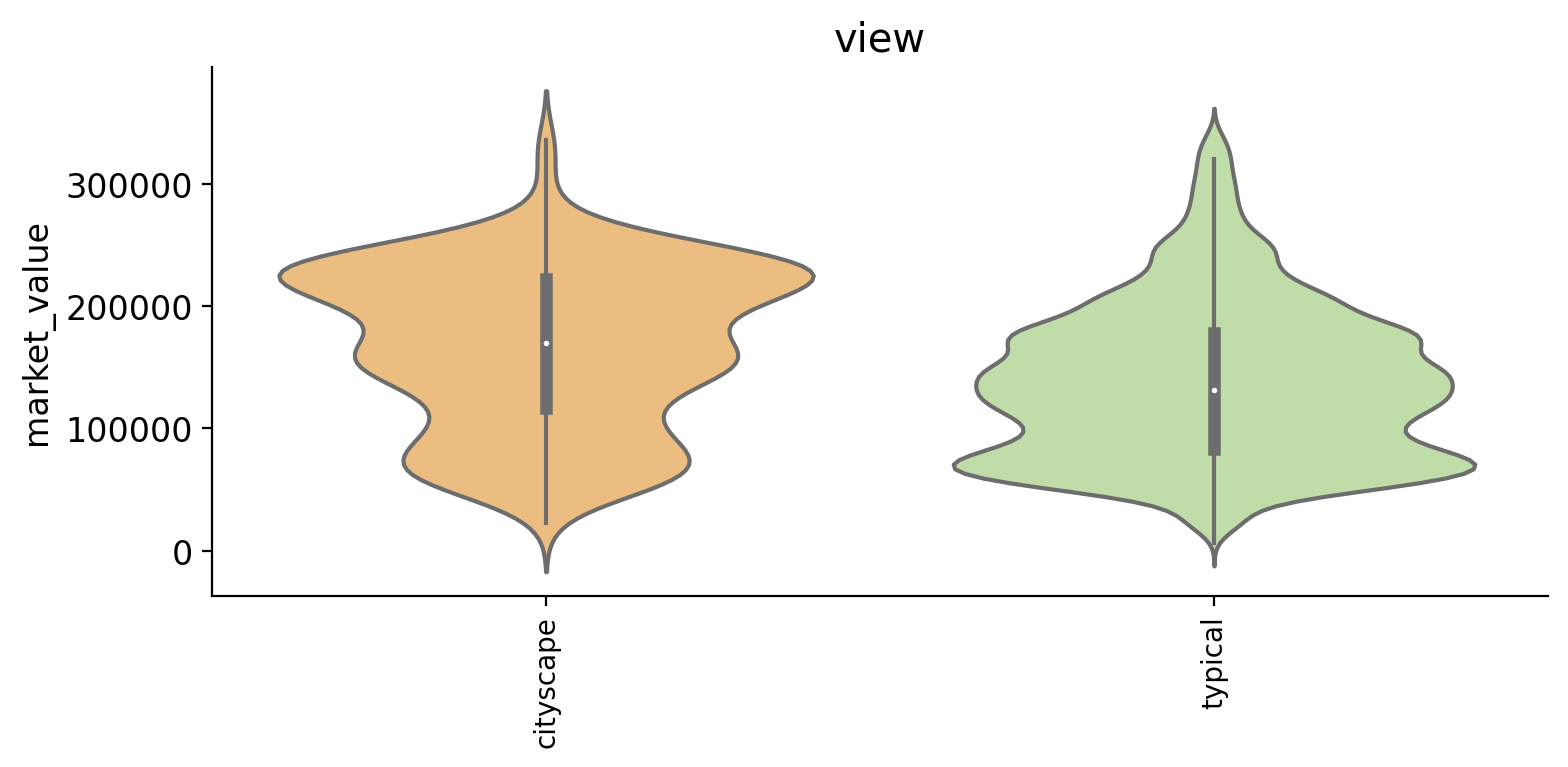

In [19]:
cnt = 0
cps = ['Paired','Set1','Set2','Set3','Dark2','Spectral']
for predictor in catdf:
    if cnt == 0:
        plt.suptitle('How does market value vary with the following home features?')
    p = sns.violinplot(data=df,x=predictor,y=target,palette=cps[cnt])
    plt.xlabel(predictor)
    sns.despine()
    plt.xticks(ticks=p.get_xticks(),labels=p.get_xticklabels(),rotation=90,fontsize=10)
    plt.title(predictor)
    plt.xlabel('')
    plt.tight_layout()
    plt.show()
    cnt += 1
figname = os.path.join(figdir,'marketvalue_catfeatures.png')
fig.savefig(figname,dpi=400,orientation='portrait', transparent=True,bbox_inches='tight')

In [20]:
# use predictive power score to see if there's a relationship between our target variable and other columns
predictors_df = pps.predictors(df, y=target,sorted=True)
predictors_df.set_index('x',inplace=True)
predictors_df.head(df.shape[0]-1)

,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
x,,,,,,,,
zip_code,market_value,0.421522,regression,True,mean absolute error,51930.7,30040.781476,DecisionTreeRegressor()
basements,market_value,0.136475,regression,True,mean absolute error,51930.7,44843.458908,DecisionTreeRegressor()
year_built,market_value,0.133555,regression,True,mean absolute error,51930.7,44995.103690,DecisionTreeRegressor()
type_heater,market_value,0.082275,regression,True,mean absolute error,51930.7,47658.118478,DecisionTreeRegressor()
interior_condition,market_value,0.078381,regression,True,mean absolute error,51930.7,47860.306828,DecisionTreeRegressor()
exterior_condition,market_value,0.071159,regression,True,mean absolute error,51930.7,48235.349404,DecisionTreeRegressor()
garage_type,market_value,0.063626,regression,True,mean absolute error,51930.7,48626.545881,DecisionTreeRegressor()
central_air,market_value,0.053415,regression,True,mean absolute error,51930.7,49156.834215,DecisionTreeRegressor()
frontage,market_value,0.051636,regression,True,mean absolute error,51930.7,49249.218844,DecisionTreeRegressor()


Location, location, location!